# <font color="blue"> AUTOMATIC TICKET CLASSIFICATION

## <font color="blue"> Introduction:

For a financial company, customer complaints carry a lot of importance, as they are often an indicator of the shortcomings in their products and servies. If these complaints are resolved efficiently in time, they can bring down the customer dissatisfaction to a minimum and retain them with stronger loyalty. This also gives them an idea of how to continuously improve their services to attract more customers.

## <font color="blue"> Problem Statement:

- These customer complaints are unstructured text data. So, traditionally companies need to allocate the task of evaluating and assigning each ticket to the relevant department to multiple support employees. This becomes tedious as the company grows and has a large customer base.
- So the company wants to automate its customer tickets system. As a financial company, the firm has many products & services such as:
   1. Credit card/prepaid card
   2. Bank account services
   3. Theft/dispute reporting
   4. Mortgages/Loans
   5. Others
- we need to build a model that is able to classify customer complaints based on the products/servies. By doing so, we can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.
- With the help of non-negative matrix factorization (NMF), an approach under topic modelling, you will detect patterns and recurring words present in each ticket. This can be then used to understand the important features for each cluster of categories.
- With the help of topic modelling, we will be able to map each ticket onto its respective department/category. we can then use this data to train any supervised model such as LOgistic Regression, Decision tree or random forest. Using this trained model, we can classify any new customer complaint support ticket into its relevant department.

## <font color="blue"> Pipeline that needs to be performed:
<font color = "black">

We are going to perform the following tasks to complete the assignment:

  1. Data loading
  2. Data preparation
  3. Text preprocessing
  4. Exploratory data analysis
  5. Feature extraction
  6. Topic modelling
  7. Model building using supervised learning
  8. Model training and evaluation
  9. Model inference

## <font color="blue"> Importing the necessary Libraries

In [1]:
# Importing the necessary libraries
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from wordcloud import WordCloud, STOPWORDS

import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
from textblob import TextBlob

# Changing the options for convenience 
pd.set_option('max_rows',None)
pd.set_option('max_columns',None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Importing warnings
import warnings
warnings.filterwarnings("ignore")

## <font color="blue"> Data Loading:
The data is in json format, and we need to convert into dataframe.

In [2]:
# opening json file and storing into the variable data
with open("/content/drive/MyDrive/Datasets/Complaints/complaints.json", "r") as f:
  data = json.loads(f.read())

# Converting the data into dataframe and also flattening the nested json
df = pd.json_normalize(data)

## <font color="blue"> Data Preparation:

In [3]:
# Inspecting the dataframe to understand the given data
df.head(2)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided


In [4]:
# Checking the shape of the dataframe
df.shape

(78313, 22)

In [5]:
# Printing the column names
print(df.columns, end=" ")

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object') 

In [6]:
# Cleaning the assigning new column names using regex
df.columns = [re.sub(r"^_(source)?\.?", "", i) for i in df.columns]
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [7]:
# Checking the info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

In [8]:
# Checking the statistical summary 
df.describe()

,score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [9]:
# Assigning nan in place of blanks in complaint column
df["complaint_what_happened"].replace("", np.nan, inplace=True)

In [10]:
# Removing all the rows where complaint column is nan
round(df.isnull().sum()/len(df) *100, 4)

index                         0.0000
type                          0.0000
id                            0.0000
score                         0.0000
tags                         86.0815
zip_code                      8.6282
complaint_id                  0.0000
issue                         0.0000
date_received                 0.0000
state                         2.5424
consumer_disputed             0.0000
product                       0.0000
company_response              0.0000
company                       0.0000
submitted_via                 0.0000
date_sent_to_company          0.0000
company_public_response      99.9949
sub_product                  13.4984
timely                        0.0000
complaint_what_happened      73.0926
sub_issue                    59.1179
consumer_consent_provided     1.2871
dtype: float64

73.09 percentage of rows have nan values, thus dropping all those rows

In [11]:
#Removing all the rows where the complaint column is nan
df.dropna(axis="index", subset= ["complaint_what_happened"], inplace=True)

In [12]:
# Checking the shape of the dataframe after dropping
round(df["complaint_what_happened"].isnull().sum()/len(df) *100, 4)

0.0

## <font color="blue"> Text Preprocessing:

**Preparing the text for topic modelling**

Doing preprocessing on text data such as:<font color="black">
1. Making the text lower case
2. Removing text in square brackets
3. Remvoing punctuation
4. Removing words containing numbers

After cleaning, we need to perform the following:
1. Lemmatizing the text
2. Extracting the pos tag of the lemmatized word and removing all the tags except NN(tag == "NN")

In [13]:
# Defining a function to clean the text and to remove all the unneccessary elements
def clean_text(text):

  # Making the text lower case
  text = text.lower()

  # Removing text in square brackets
  text = re.sub(r"\[.*?\]","",text)

  # Removing punctuation
  text = re.sub(r"[%s]%re.escape(string.punctuation)","",text)

  # Removing words containing numbers
  text = re.sub(r"\w*\d+\w*","",text)

  return text

In [14]:
# Cleaning the complaint column using the clean_text function
df["complaint_what_happened"] = [clean_text(x) for x in df["complaint_what_happened"]]

In [15]:
# Creating the function to lemmatize the text
def lemmatize(text):
  
  # Creating a list to store the lemmatized words
  lemma_list = []

  # Extrating the lemmas from the given text
  doc = nlp(text)
  for token in doc:
    lemma_list.append(token.lemma_)

  # Converting the string into list
  string = " ".join(lemma_list)

  return string

In [16]:
# Creating a seperate column in the dataframe for the lemmatized text
df["lemmatized_complaints"] = [lemmatize(text) for text in df["complaint_what_happened"]]

In [17]:
# Creating a dataframe df_clean contatining the complaints and lemmatized complaints
df_clean = df[["complaint_what_happened","lemmatized_complaints"]]

In [18]:
# Defining the function to extract the pos tags of the sentence
def pos_tag(text):

  # Extracting the pos tag using TextBlob package
  textblob = TextBlob(text)
  NN_tagged_words = []

  for word,tag in textblob.tags:
    if tag == "NN":
      NN_tagged_words.append(word)

  # Converting the list into string
  string = " ".join(NN_tagged_words)

  return string


# Creating a column complaint_pos_removed which has only singular nouns (NN)
df_clean["complaint_POS_removed"] = [pos_tag(text) for text in df_clean["lemmatized_complaints"]]

In [19]:
# Inspecting the df_Clean dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.","on xx / xx/ , while 

## <font color="blue"> Exploratory Data Analysis:

Let's perform the following tasks:
- Visualizing the data according to the complaint character length
- Finding the top 40 words by frequency among all  the articles after processing the text using a word cloud
- Finding the top unigrams, bigrams and trigrams by frequency among all the complaints after processing the text

In [20]:
# Checking the length of the characters in complaint_POS_removed column
char_len = [len(x) for x in df_clean["complaint_POS_removed"]]

In [21]:
# Visualizing the histogram of the lengths of complaint_pos_removed column using plotly
fig = px.histogram(char_len, title="Distribution of Complaint Character Length",template="simple_white")
fig.update_layout(xaxis_title = "Complaint character length")
fig.update_layout(showlegend=False)
fig.show()

**Finding the top 40 words by frequency among all the articles after processing the text.**

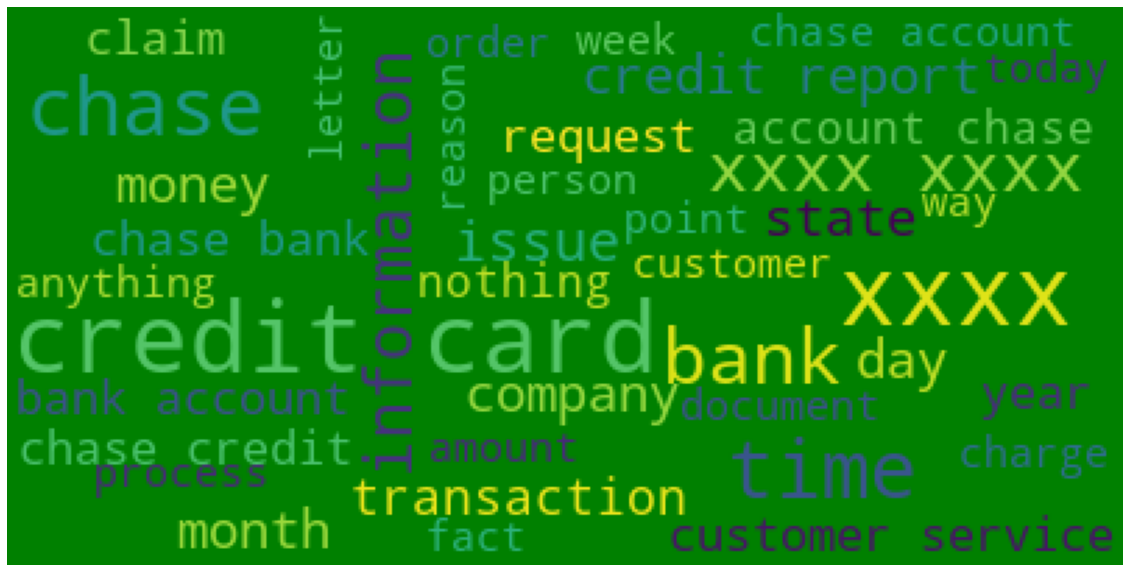

In [22]:
# Using the word cloud library lets find the top 40 words by frequency among all the articles after processing the text

# Storing the stop words in a variabel
stop_words = set(STOPWORDS)

# Creating the text column from which we need to find out top 40 words by frequency
text_column = df_clean["complaint_POS_removed"]

# Instantiating wordcloud and generating
word_cloud = WordCloud( background_color="green",
                       stopwords=stop_words,
                       max_font_size=35,
                       max_words = 40,
                       random_state = 100)
word_cloud.generate(str(text_column))

# Plotting the top 40 words
fig = plt.figure(figsize=(20,16))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [23]:
# Removing --PRON-- from the text corpus
df_clean["Complaint_clean"] = df_clean["complaint_POS_removed"].str.replace("-PRON", "")

**Finding the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.**

In [24]:
 # Finding the top 30 unigram frequency among the complaints in the cleaned dataframe
 def top_unigram(text_corpus, n=30):

   # Instantiating the count vectorizer
   vector = CountVectorizer(stop_words="english").fit(text_corpus)

   # Creating the bag of words matrix for the text corpus
   bag_of_words = vector.transform(text_corpus)

   # Summing up the word counts for all the sentences 
   sum_of_words = bag_of_words.sum(axis=0)

   # Extracting the word and its count using the index
   word_count = [(word, sum_of_words[0,idx]) for word, idx in vector.vocabulary_.items()]

   # Sorting the word_count in descending order
   word_count = sorted(word_count, key=lambda x:x[1], reverse=True)

   return word_count[:n]

In [25]:
# Printing the top 10 words in the unigram frequency
top_unigram_words = top_unigram(df_clean["Complaint_clean"], n=30)
df_unigram = pd.DataFrame(top_unigram_words, columns=["Unigram","Count"])
df_unigram[:10]

,Unigram,Count
0,chase,49099
1,account,47897
2,xxxx,43172
3,credit,34283
4,card,29632
5,bank,28508
6,payment,21336
7,time,16289
8,charge,15151
9,day,13065


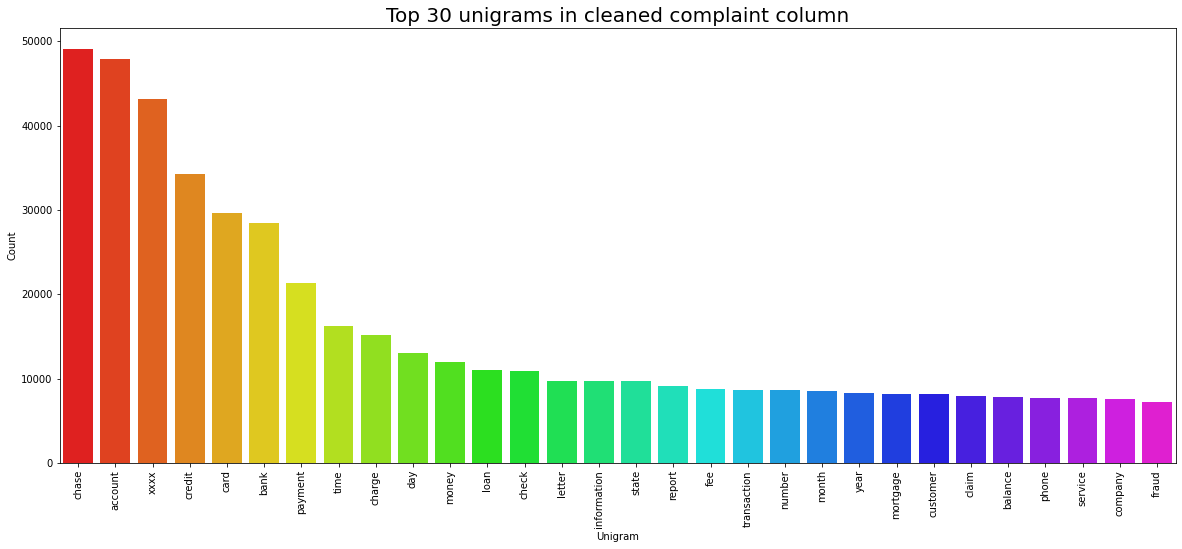

In [26]:
# Plotting barplot for the top 30 unigrams
plt.figure(figsize=(20,8))
sns.barplot(data=df_unigram, x="Unigram", y="Count", palette="gist_rainbow")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in cleaned complaint column", fontsize=20)
plt.show()

In [27]:
 # Finding the top 30 bigram frequency among the complaints in the cleaned dataframe
 def top_bigram(text_corpus, n=30):

   # Instantiating the count vectorizer
   vector = CountVectorizer(ngram_range=(2,2), stop_words="english").fit(text_corpus)

   # Creating the bag of words matrix for the text corpus
   bag_of_words = vector.transform(text_corpus)

   # Summing up the word counts for all the sentences 
   sum_of_words = bag_of_words.sum(axis=0)

   # Extracting the word and its count using the index
   word_count = [(word, sum_of_words[0,idx]) for word, idx in vector.vocabulary_.items()]

   # Sorting the word_count in descending order
   word_count = sorted(word_count, key=lambda x:x[1], reverse=True)

   return word_count[:n]

In [28]:
# Printing the top 10 words in the bigram frequency
top_bigram_words = top_bigram(df_clean["Complaint_clean"], n=30)
df_bigram = pd.DataFrame(top_bigram_words, columns=["bigram","Count"])
df_bigram[:10]

,bigram,Count
0,credit card,12879
1,xxxx xxxx,6198
2,credit report,4002
3,customer service,3080
4,chase credit,3058
5,chase bank,2898
6,bank account,2807
7,chase account,2769
8,account chase,2751
9,account account,2335


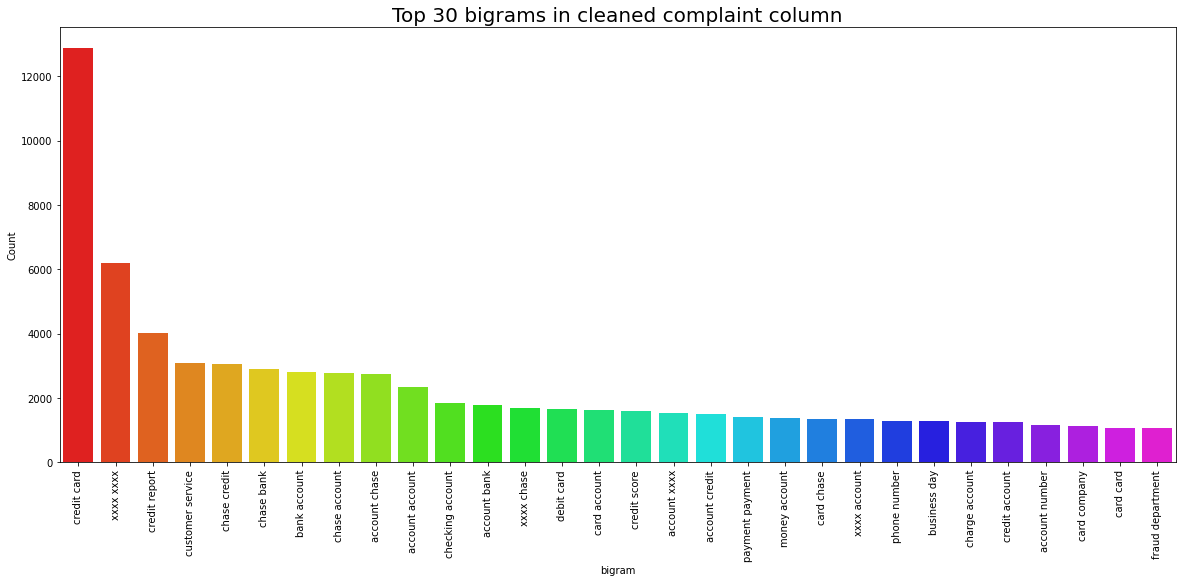

In [29]:
# Plotting barplot for the top 30 bigrams
plt.figure(figsize=(20,8))
sns.barplot(data=df_bigram, x="bigram", y="Count", palette="gist_rainbow")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in cleaned complaint column", fontsize=20)
plt.show()

In [30]:
 # Finding the top 30 trigram frequency among the complaints in the cleaned dataframe
 def top_trigram(text_corpus, n=30):

   # Instantiating the count vectorizer
   vector = CountVectorizer(ngram_range=(3,3), stop_words="english").fit(text_corpus)

   # Creating the bag of words matrix for the text corpus
   bag_of_words = vector.transform(text_corpus)

   # Summing up the word counts for all the sentences 
   sum_of_words = bag_of_words.sum(axis=0)

   # Extracting the word and its count using the index
   word_count = [(word, sum_of_words[0,idx]) for word, idx in vector.vocabulary_.items()]

   # Sorting the word_count in descending order
   word_count = sorted(word_count, key=lambda x:x[1], reverse=True)

   return word_count[:n]

In [31]:
# Printing the top 10 words in the bigram frequency
top_trigram_words = top_trigram(df_clean["Complaint_clean"], n=30)
df_trigram = pd.DataFrame(top_trigram_words, columns=["trigram","Count"])
df_trigram[:10]

,trigram,Count
0,chase credit card,2135
1,xxxx xxxx xxxx,1060
2,credit card account,1057
3,credit card company,994
4,credit card chase,672
5,credit card credit,509
6,inquiry credit report,482
7,charge credit card,431
8,account credit card,418
9,card credit card,382


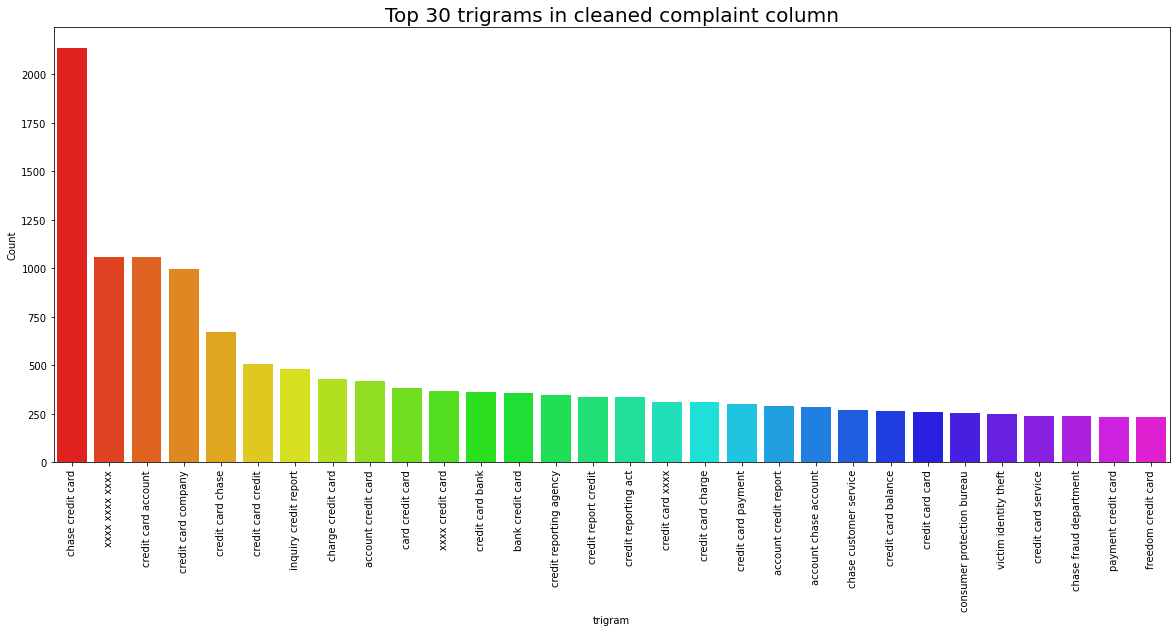

In [32]:
# Plotting barplot for the top 30 trigrams
plt.figure(figsize=(20,8))
sns.barplot(data=df_trigram, x="trigram", y="Count", palette="gist_rainbow")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in cleaned complaint column", fontsize=20)
plt.show()

**The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis**

In [33]:
# Cleaning the mask in the corpus
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [34]:
# Inspecting the dataframe
df_clean.head(3)

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent,card agent upgrade date agent information order account change date consent recording agent
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,card application identity consent service credit identity applicant


## <font color="blue"> Feature Extraction

Converting the raw texts to matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words" max_df = 0.95 means ignoring terms that appear in more than 95% of complaints.

**min_df** is used for removing terms that appear too infrequently min_df=2 means ignoring terms that appear in less than 2 complaints.

In [35]:
# Instializing the tf-idf vectorizer
tf_idf = TfidfVectorizer(max_df = 0.95, min_df=2, stop_words="english")

**Creating a document term matrix using fit_transform**:

The contents of a document term matrix are tuple of (complaint_id, token_id) tf-idf score: The tuples that are not there have a tf-idf score of 0

In [36]:
# Creating the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tf_idf.fit_transform(df_clean["Complaint_clean"])

The shape of the tf_idf matrix is 21072 x 7061

## <font color="blue"> Topic Modelling:

Non-Negative Matrix Factorization(NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that,NMF decomposes of factorizes high dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative

In this task you have to perform the following:
- Find the best number of clusters
- Apply the best number to create word clusters
- Inspect and validate the correction of each cluster with respect to the complaints
- Correct the labels if needed
- Map the clusters to topics/cluster names

In [37]:
# Importing the nmf library
from sklearn.decomposition import NMF

### Manual Topic Modelling:

We need to do take the trial and error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.


In [38]:
# Loading your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [39]:
# fitting the model
nmf_model.fit(dtm)

# Checking the number of unique words
len(tf_idf.get_feature_names())

7061

In [40]:
# Printing the Top15 words for each of the topics using topic word matrix
for index, topic in enumerate(nmf_model.components_):
  print(f"\033[1m Top 15 words for - Topic {index} \033[1m")
  print(list(tf_idf.get_feature_names()[i] for i in topic.argsort()[-15:]))
  print("-"*100)

 Top 15 words for - Topic 0 
['transfer', 'claim', 'transaction', 'business', 'number', 'checking', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'check', 'bank', 'account']
----------------------------------------------------------------------------------------------------
 Top 15 words for - Topic 1 
['year', 'balance', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']
----------------------------------------------------------------------------------------------------
 Top 15 words for - Topic 2 
['mortgage', 'year', 'chase', 'credit', 'account', 'date', 'pay', 'time', 'day', 'auto', 'statement', 'fee', 'month', 'balance', 'payment']
----------------------------------------------------------------------------------------------------
 Top 15 words for - Topic 3 
['company', 'refund', 'statement', 'time', 'service', 'claim', 'purchase', 'fraud', 'merchant', 'transaction', 'dispute', 'fee', 'ch

In [41]:
# Creating the best topic for each complaint in terms of integer value 0,1,2,3 & 4

# Extracting the document topic matrix
document_topic = nmf_model.transform(dtm)

# Extracting the topic i.e index of the highest number for the document
topic_labels = document_topic.argmax(axis=1)
topic_labels

array([4, 1, 1, ..., 3, 2, 2])

In [42]:
# Assigning the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_labels

# Inspecting df_Clean dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent,card agent upgrade date agent information order account change date consent recording agent,1
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,1
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the 

In [43]:
# Printing the first 5 complaints for each of the topics
df_clean_samples = df_clean.groupby("Topic").head(5)
df_clean_samples.sort_values("Topic")

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
14,my grand son give me check for {$.} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen xx/xx/ check number xxxx claim number is xxxx with chase,my grand son give I check for { $ . } I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay I my money my grand son call chase time they tell he I should call not he to verify the check owner he be out the country most the time date happen xx / xx/ check number xxxx claim number be xxxx with chase,son chase account fund bank account pay money son check money bank refuse money son call chase time check owner country time date number claim number chase,son chase account fund bank account pay money son check money bank refuse money son call chase time check owner country time date number claim number chase,0
17,"with out notice j.p. morgan chase restricted my account by my debit card tuesday xx/xx/. on thursday xx/xx/ i went into a branch after being advised by a customer service representative that my account would actually be closed. i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day. that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday, xx/xx/. upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement. ive been called and i was told that it may take two business day stating tuesday, xx/xx/xxxx would be the date that my funds would be available to withdraw from a bank teller only. now, chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently. unfortunately, this has put me in an additional financial bind do two fees from late rent late car payments, etc. i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document. i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document. this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally. thank you","with out notice j.p . morgan chase restrict my account by my debit card tuesday xx / xx/. on thursday xx / xx/ I go into a branch after be advise by a customer service representative that my account would actually be close . I go into the branch to see how I can remove the fund that be in there currently in as well as if my direct deposit from my place of employment would be return . the bank asso

**After evaluating the mapping, if the topics assigned are correct then assifn these names to the relevant topic:

- Bank Account services
- Credit card or prepaid card
- Theft/dispute reporting
- Mortgage/Loan
- Others

In [44]:
# Creating the dictionary of Topic names and Topics
Topic_names = {0:"Bank Account services", 1:"Credit card or prepaid card", 2:"Others",
               3:"Theft/Dispute Reporting", 4:"Mortgage/Loan"}

# Replacing Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [45]:
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,Mortgage/Loan
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent,card agent upgrade date agent information order account change date consent recording agent,Credit card or prepaid card
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,Credit card or prepaid card
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proc

## <font color="blue"> Model Building using Supervised learning

**Supervised model to predict any new complaints to the relevant Topics.**

You have now build the model to create the topics for each complaints. Now in the below section you will use them to classify any new complaints

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [46]:
#Create the dictionary again of Topic names and Topics
Topic_names = {"Bank Account services":0, "Credit card or prepaid card":1, "Others":2,
               "Theft/Dispute Reporting":3, "Mortgage/Loan":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [47]:
# Inspecting the data
df_clean.head(3)

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent,card agent upgrade date agent information order account change date consent recording agent,1
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,1


In [48]:
# Keeping the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint_what_happened',"Topic"]]

# Inspecting the shape of the training data
training_data.shape

(21072, 2)

In [49]:
# Inspecting training data
training_data.head()

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,1
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.",1
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.",1
14,my grand son give me check for {$.} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen xx/xx/ check number xxxx claim number is xxxx with chase,0


In [50]:
# Checking the value counts of the topic
training_data["Topic"].value_counts()

0    5219
1    4964
3    4802
4    3814
2    2273
Name: Topic, dtype: int64

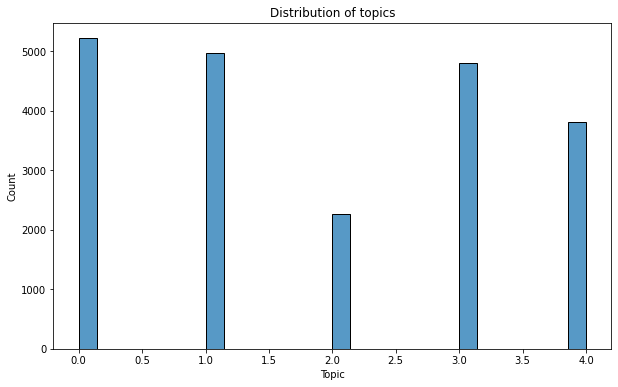

In [51]:
# Plotting bar plot for value counts
plt.figure(figsize=[10,6])
fig = sns.histplot(training_data, x="Topic")
plt.title("Distribution of topics")
plt.show()

In [52]:
# Building a function for evaluation
def model_evaluation(true, predicted, model):
  y_labels = ["Bank Account services", "Credit card or prepaid card", "Others","Theft/Dispute Reporting", "Mortgage/Loan"]

  # Printing the classification report
  print(f"Classfication report for {model} \n")
  print(classification_report(true, predicted, target_names = y_labels))

  # Printing the confusion marix
  matrix = confusion_matrix(true, predicted)
  plt.figure(figsize=[8,8])
  plt.title(f"Confustion matrix for {model}")
  sns.heatmap(matrix, annot=True, cmap="Blues", cbar=None, xticklabels=y_labels, yticklabels=y_labels)
  plt.show()

  return 

**Appling the supervised models on the training data created. In this process, we have to do the following:**
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics

In [53]:
# Writing the code to get the vector count

# Instantiating count vectorizer
count_vector = CountVectorizer()

# fitting and transforming the data
X_train_count = count_vector.fit_transform(training_data["complaint_what_happened"])

In [54]:
# Writing the code to transform the word vector to tf-idf

# Instantiating tfidf transformer
tfidf_transform = TfidfTransformer()

# fitting and transforming the data
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

In [55]:
# Splitting the x_train_tfidf into train and validation set
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

# Inspecting the shape
print("Shape of X_train", X_train.shape)
print("Shape of X_test", X_test.shape)
print("Shape of y_train", y_train.shape)
print("Shape of y_test", y_test.shape)

Shape of X_train (15804, 27984)
Shape of X_test (5268, 27984)
Shape of y_train (15804,)
Shape of y_test (5268,)


**Trying the below models:**
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

Using the required evaluation metrics lets judge the tried models and select the ones performing the best

##<font color="blue"> Model Training and Evaluation

### Logistic Regression

In [56]:
# Import required library
from sklearn.linear_model import LogisticRegression

In [57]:
# Instantiating and fitting the model
log = LogisticRegression()

# fitting the model
log.fit(X_train, y_train)

LogisticRegression()

In [58]:
# Evaluating the train score
y_pred_train = log.predict(X_train)
f1_train_log = f1_score(y_train, y_pred_train, average="weighted")
f1_train_log

0.9695101228715182

In [59]:
# Evaluating the test score
y_pred_test = log.predict(X_test)
f1_test_log = f1_score(y_test, y_pred_test, average="weighted")
f1_test_log

0.9249079831490344

Classfication report for Logistic Regression 

                             precision    recall  f1-score   support

      Bank Account services       0.92      0.95      0.94      1313
Credit card or prepaid card       0.93      0.93      0.93      1271
                     Others       0.96      0.87      0.91       563
    Theft/Dispute Reporting       0.90      0.90      0.90      1203
              Mortgage/Loan       0.93      0.93      0.93       918

                   accuracy                           0.93      5268
                  macro avg       0.93      0.92      0.92      5268
               weighted avg       0.93      0.93      0.92      5268



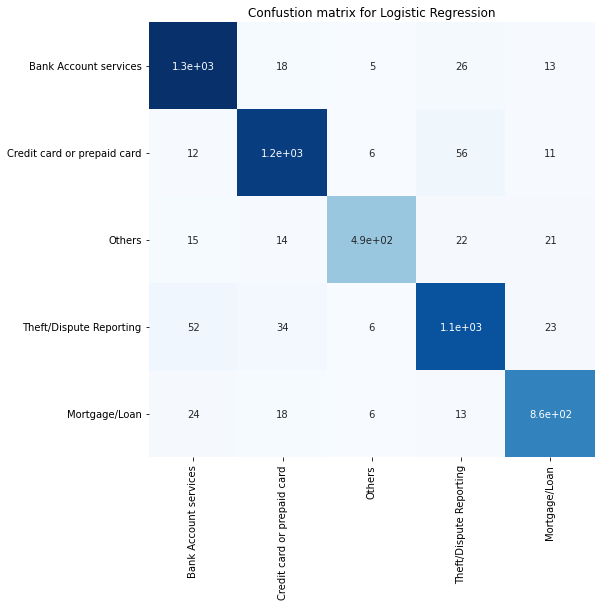

In [60]:
# Checking the classfication report and confusion matrix
model_evaluation(y_test, y_pred_test, "Logistic Regression")

**Tuning some hyperparameters**

In [61]:
# Hyperparameter tuning for best result
param_log = {"penalty":["l1","l2"],
             "C":[0.01,0.1,1,10],
             "solver":["lbfgs","liblinear","newton-cg"]}
cv = 5
grid_search = GridSearchCV(estimator = log,
                           param_grid=param_log,
                           verbose=1,
                           scoring="f1_weighted",
                           cv = cv)
grid_search.fit(X_train, y_train)

# Checking the best parameters
print(grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [62]:
# Instantiating and fitting the model using tuned hyperparmeters
log = LogisticRegression(C=1, penalty="l1", solver="liblinear")

# fitting the model
log.fit(X_train, y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [63]:
# Evaluating the train score
y_pred_train = log.predict(X_train)
f1_train_log_tuned = f1_score(y_train, y_pred_train, average="weighted")
f1_train_log_tuned

0.9504171568157072

In [64]:
# Evaluating the test score
y_pred_test = log.predict(X_test)
f1_test_log_tuned = f1_score(y_test, y_pred_test, average="weighted")
f1_test_log_tuned

0.9438937279898822

Classfication report for Logistic Regression 

                             precision    recall  f1-score   support

      Bank Account services       0.95      0.96      0.95      1313
Credit card or prepaid card       0.94      0.96      0.95      1271
                     Others       0.93      0.93      0.93       563
    Theft/Dispute Reporting       0.94      0.91      0.93      1203
              Mortgage/Loan       0.95      0.94      0.95       918

                   accuracy                           0.94      5268
                  macro avg       0.94      0.94      0.94      5268
               weighted avg       0.94      0.94      0.94      5268



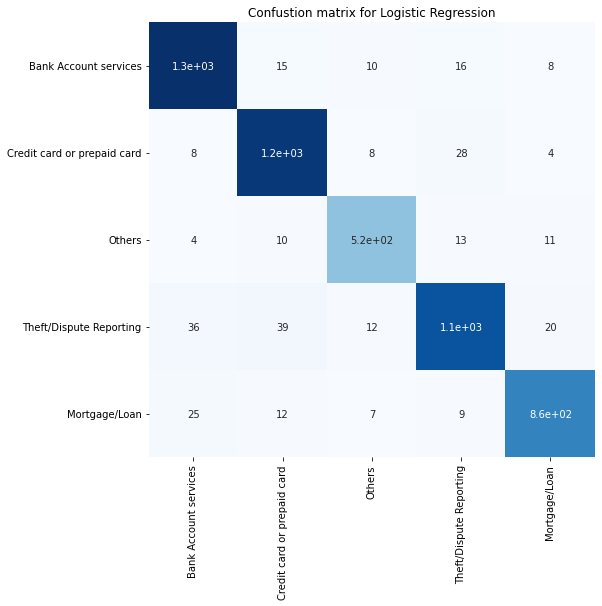

In [65]:
# Checking the classfication report and confusion matrix
model_evaluation(y_test, y_pred_test, "Logistic Regression")

### Decision Tree

In [66]:
# Import required library
from sklearn.tree import DecisionTreeClassifier

In [67]:
# Instantiating the algorithm
dt = DecisionTreeClassifier(max_depth=10, random_state=42)

# Fittting the model
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [68]:
# Checking the train score
y_pred_train = dt.predict(X_train)
f1_train_dt = f1_score(y_train, y_pred_train, average="weighted")
f1_train_dt

0.8402117787607964

In [69]:
# Checking the test score
y_pred_test = dt.predict(X_test)
f1_test_dt = f1_score(y_test, y_pred_test, average="weighted")
f1_test_dt

0.7667957016140637

Classfication report for Decision Tree 

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.79      0.79      1313
Credit card or prepaid card       0.81      0.83      0.82      1271
                     Others       0.78      0.72      0.75       563
    Theft/Dispute Reporting       0.78      0.63      0.70      1203
              Mortgage/Loan       0.69      0.86      0.76       918

                   accuracy                           0.77      5268
                  macro avg       0.77      0.77      0.76      5268
               weighted avg       0.77      0.77      0.77      5268



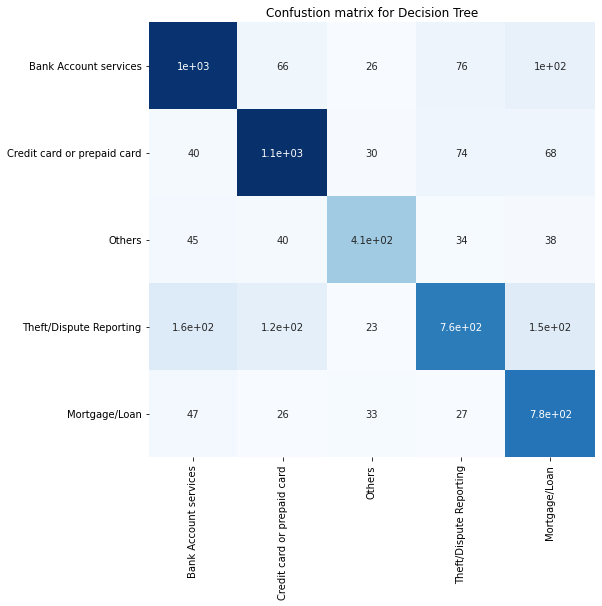

In [70]:
# Checking the classfication report and confusion matrix
model_evaluation(y_test, y_pred_test, "Decision Tree")

**Tuning some hyperparameters**

In [71]:
# Hyperparameter tuning 
dt = DecisionTreeClassifier(random_state=42)
param_dt = {"criterion":["gini","entropy"],
            "max_depth":[5,10,15,20,25],
            "min_samples_leaf":[10,15,20,30,40]}
cv = 4

grid_search = GridSearchCV(estimator = dt,
                           param_grid = param_dt,
                           verbose=1,
                           scoring="f1_weighted",
                           cv = cv,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# Printing the best params
print(grid_search.best_params_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
{'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 15}


In [72]:
# Instantiating and fitting the model using tuned hyperparmeters
dt = DecisionTreeClassifier(criterion="gini" ,max_depth= 25 ,min_samples_leaf= 15)

# fitting the model
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=25, min_samples_leaf=15)

In [73]:
# Evaluating the train score
y_pred_train = dt.predict(X_train)
f1_train_dt_tuned = f1_score(y_train, y_pred_train, average="weighted")
f1_train_dt_tuned

0.8569311400786201

In [74]:
# Evaluating the test score
y_pred_test = dt.predict(X_test)
f1_test_dt_tuned = f1_score(y_test, y_pred_test, average="weighted")
f1_test_dt_tuned

0.7985248827860317

Classfication report for Decision Tree 

                             precision    recall  f1-score   support

      Bank Account services       0.79      0.83      0.81      1313
Credit card or prepaid card       0.84      0.81      0.83      1271
                     Others       0.77      0.77      0.77       563
    Theft/Dispute Reporting       0.76      0.73      0.75      1203
              Mortgage/Loan       0.81      0.84      0.82       918

                   accuracy                           0.80      5268
                  macro avg       0.80      0.80      0.80      5268
               weighted avg       0.80      0.80      0.80      5268



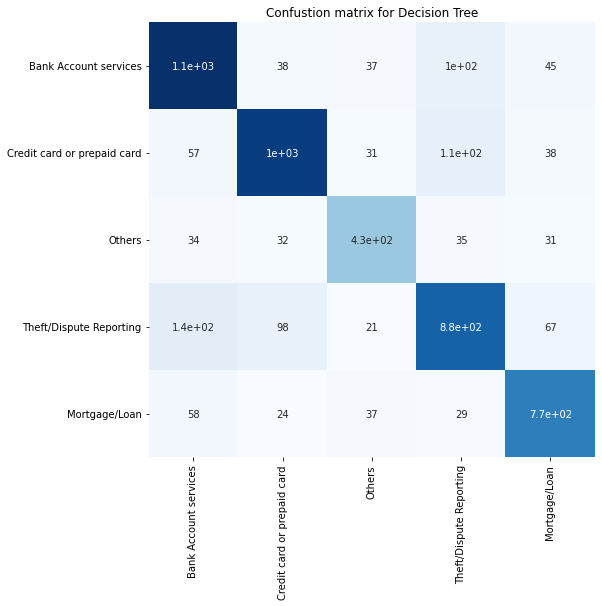

In [75]:
# Checking the classfication report and confusion matrix
model_evaluation(y_test, y_pred_test, "Decision Tree")

### Random Forest

In [76]:
# Import required library
from sklearn.ensemble import RandomForestClassifier

In [77]:
# Instantiating the algorithm
rf = RandomForestClassifier(max_depth=10, random_state=42)

# Fittting the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [78]:
# Evaluating the train score
y_pred_train = rf.predict(X_train)
f1_train_rf = f1_score(y_train, y_pred_train, average="weighted")
f1_train_rf

0.7318313385778057

In [79]:
# Evaluating the test score
y_pred_test = rf.predict(X_test)
f1_test_rf = f1_score(y_test, y_pred_test, average="weighted")
f1_test_rf

0.6887172017751461

Classfication report for Random Forest 

                             precision    recall  f1-score   support

      Bank Account services       0.71      0.89      0.79      1313
Credit card or prepaid card       0.64      0.86      0.74      1271
                     Others       1.00      0.02      0.04       563
    Theft/Dispute Reporting       0.77      0.75      0.76      1203
              Mortgage/Loan       0.87      0.70      0.78       918

                   accuracy                           0.73      5268
                  macro avg       0.80      0.65      0.62      5268
               weighted avg       0.77      0.73      0.69      5268



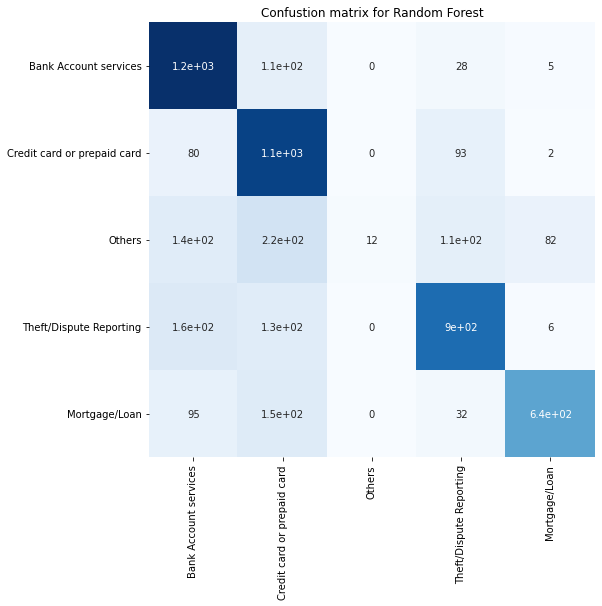

In [80]:
# Checking the classfication report and confusion matrix
model_evaluation(y_test, y_pred_test, "Random Forest")

**Tuning some hyperparameters**

In [100]:
# Hyperparameter tuning 
rf = RandomForestClassifier(random_state=42)
param_rf = {"n_estimators":[20,30,50,80,100],
            "criterion":["gini","entropy"],
            "max_depth":[5,10,25,30],
            "min_samples_leaf":[5,10,20,30],
            "min_samples_split":[4,10,15]}

cv = 4
grid_search = RandomizedSearchCV(estimator = rf,
                           param_distributions = param_rf,
                           verbose=1,
                           scoring="f1_weighted",
                           n_iter=25,
                           cv = cv,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# Printing the best params
print(grid_search.best_params_)

Fitting 4 folds for each of 25 candidates, totalling 100 fits
{'n_estimators': 80, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 25, 'criterion': 'gini'}


In [101]:
# Instantiating the algorithm
rf = RandomForestClassifier(n_estimators=80, min_samples_split=10, min_samples_leaf=5,
                            criterion="gini", max_depth=25, random_state=42)

# Fittting the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=80, random_state=42)

In [102]:
# Evaluating the train score
y_pred_train = rf.predict(X_train)
f1_train_rf_tuned = f1_score(y_train, y_pred_train, average="weighted")
f1_train_rf_tuned

0.8580224214638115

In [103]:
# Evaluating the test score
y_pred_test = rf.predict(X_test)
f1_test_rf_tuned = f1_score(y_test, y_pred_test, average="weighted")
f1_test_rf_tuned

0.7661915787909003

Classfication report for Random Forest 

                             precision    recall  f1-score   support

      Bank Account services       0.77      0.91      0.83      1313
Credit card or prepaid card       0.75      0.86      0.80      1271
                     Others       0.97      0.24      0.38       563
    Theft/Dispute Reporting       0.79      0.79      0.79      1203
              Mortgage/Loan       0.84      0.82      0.83       918

                   accuracy                           0.78      5268
                  macro avg       0.82      0.72      0.73      5268
               weighted avg       0.80      0.78      0.77      5268



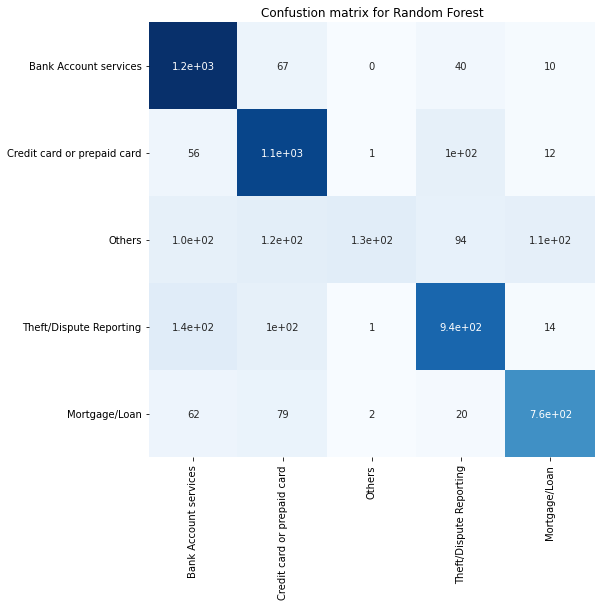

In [104]:
# Checking the classfication report and confusion matrix
model_evaluation(y_test, y_pred_test, "Random Forest")

### Gaussian Naive Bayes

In [86]:
# Import required library
from sklearn.naive_bayes import MultinomialNB

In [87]:
# Instantiating the algorithm
nb = MultinomialNB()

# Fittting the model
nb.fit(X_train, y_train)

MultinomialNB()

In [88]:
# Evaluating the train score
y_pred_train = nb.predict(X_train)
f1_train_nb = f1_score(y_train, y_pred_train, average="weighted")
f1_train_nb

0.7221696797651769

In [89]:
# # Evaluating the test score
y_pred_test = nb.predict(X_test)
f1_test_nb = f1_score(y_test, y_pred_test, average="weighted")
f1_test_nb

0.6827607001853209

Classfication report for Naive Bayes 

                             precision    recall  f1-score   support

      Bank Account services       0.65      0.92      0.76      1313
Credit card or prepaid card       0.72      0.75      0.74      1271
                     Others       0.90      0.02      0.03       563
    Theft/Dispute Reporting       0.74      0.77      0.76      1203
              Mortgage/Loan       0.85      0.76      0.80       918

                   accuracy                           0.72      5268
                  macro avg       0.77      0.64      0.62      5268
               weighted avg       0.75      0.72      0.68      5268



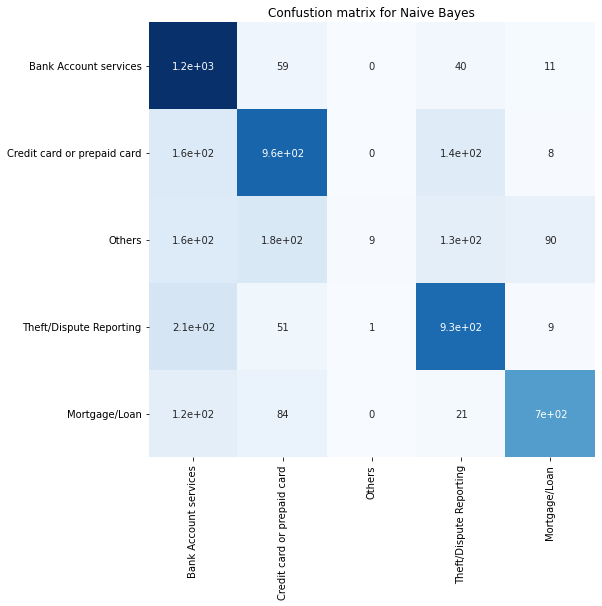

In [90]:
# Checking the classfication report and confusion matrix
model_evaluation(y_test, y_pred_test, "Naive Bayes")

**Tuning some hyperparameters**

In [91]:
# Tuning some hyperparameters
nb = MultinomialNB()
param_nb = {"alpha":[1,0.1,0.01,0.001,0.0001],
            "fit_prior":[True, False]}
cv = 5
grid_search = GridSearchCV(estimator = nb,
                           param_grid=param_nb,
                           scoring="f1_weighted",
                           verbose=1,
                           cv = cv)
grid_search.fit(X_train, y_train)

# Getting the best params
print(grid_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'alpha': 0.1, 'fit_prior': False}


In [92]:
# Instantiating the algorithm
nb = MultinomialNB(alpha=0.1, fit_prior=False)

# Fittting the model
nb.fit(X_train, y_train)

MultinomialNB(alpha=0.1, fit_prior=False)

In [93]:
# Evaluating the train score
y_pred_train = nb.predict(X_train)
f1_train_nb_tuned = f1_score(y_train, y_pred_train, average="weighted")
f1_train_nb_tuned

0.8735863496810372

In [94]:
# Evaluating the test score
y_pred_test = nb.predict(X_test)
f1_test_nb_tuned = f1_score(y_test, y_pred_test, average="weighted")
f1_test_nb_tuned

0.7794354693759302

Classfication report for Naive Bayes 

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.83      0.80      1313
Credit card or prepaid card       0.80      0.75      0.78      1271
                     Others       0.66      0.64      0.65       563
    Theft/Dispute Reporting       0.77      0.77      0.77      1203
              Mortgage/Loan       0.84      0.84      0.84       918

                   accuracy                           0.78      5268
                  macro avg       0.77      0.77      0.77      5268
               weighted avg       0.78      0.78      0.78      5268



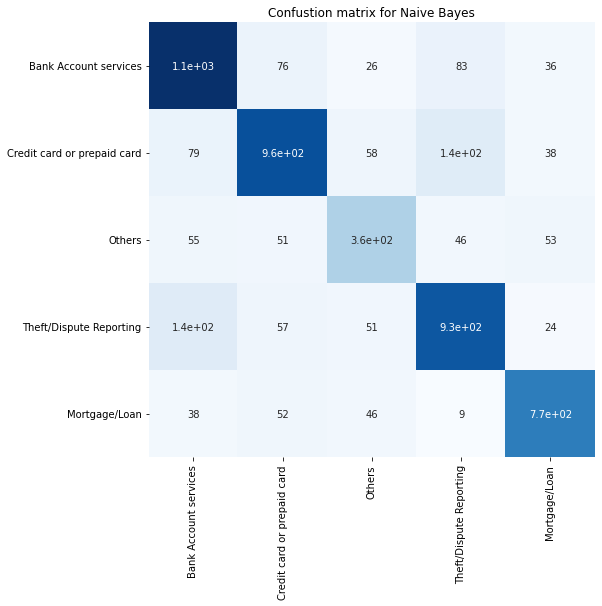

In [95]:
# Checking the classfication report and confusion matrix
model_evaluation(y_test, y_pred_test, "Naive Bayes")

## <font color="blue"> Model inference

**Conclusion**

F1_score of the models are:

- Logistic Regression -  0.94
- Decision Tree  - 0.80
- Random Forest - 0.77
- Naive Bayes - 0.78

**From the above scores it is evident that the logistic regression model is performing well for the custom data.**